<a href="https://colab.research.google.com/github/itsalanthomas/shipping-optimization/blob/dev/src/Ecommerce_Optimization_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# load libraries
from google.colab import files
from io import StringIO
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_curve, roc_auc_score


# load data in with file simulation
uploaded = files.upload()
filename = 'ecommerce_shipping.csv'

with open(filename, 'r') as file:
  csv_text = file.read()

# create df
df = pd.read_csv(StringIO(csv_text))

# EDA - Exploratory Data Analysis
df.info()
df.describe()
df.isnull().sum() #check count of null values in columns
df[df.isnull().any(axis = 1)] #check if there are any missing values in rows

# rename columns
new_cols = []
for col in df.columns:
    new_col = col.replace('_', ' ').title()
    new_cols.append(new_col)

df.columns = new_cols
df.rename(columns={'Reached.On.Time Y.N': 'On-time Delivery'},inplace=True)


Saving ecommerce_shipping.csv to ecommerce_shipping (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [16]:
#creating dictionary to map the order for importance
product_order = {'low': 0 ,'medium':1, 'high':2}
df['Product Importance'] = df['Product Importance'].map(product_order)

#New features from dataset.
df['Total Price'] = df['Cost Of The Product'] - df['Discount Offered']
df['Cost Rate'] = round((df['Cost Of The Product']/df['Discount Offered']), 2)
df['Status of Mode by Shipment'] = df['Mode Of Shipment'].map(df.groupby('Mode Of Shipment')['On-time Delivery'].mean())

In [17]:
#columns to encode and initialize encoder
columns = ['Warehouse Block','Mode Of Shipment', 'Gender']
encoder = pd.get_dummies(df[columns], drop_first=True)
encoder = encoder.astype(int)
df_new = pd.concat([df.drop(columns = columns), encoder], axis=1)

In [18]:
#Scaling nominal data
scaler = StandardScaler()
columns_to_scale = ['Customer Rating','Cost Of The Product',
                    'Prior Purchases', 'Product Importance',
                    'Discount Offered', 'Weight In Gms',
                    'Total Price','Cost Rate','Status of Mode by Shipment']
df_new_scaled = scaler.fit_transform(df_new[columns_to_scale])
df_new_scaled = pd.DataFrame(df_new_scaled, columns = columns_to_scale)
df_new_scaled = pd.concat([df_new.drop(columns = columns_to_scale), df_new_scaled], axis = 1)

In [19]:
#Checking for multicollinearity values greater than 5 (ignoring the total price since that was created from two other features)
#taking out correlated columns (price ones)
df_vif = df_new_scaled.drop(columns = ['Total Price','Cost Of The Product','Discount Offered','Cost Rate'])

vif = pd.DataFrame()
vif['feature']  = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif)

                       feature        VIF
0                           Id   1.374781
1          Customer Care Calls   1.194988
2             On-time Delivery   1.248506
3            Warehouse Block_B   1.667148
4            Warehouse Block_C   1.667247
5            Warehouse Block_D   1.667487
6            Warehouse Block_F   2.001018
7        Mode Of Shipment_Road  35.475950
8        Mode Of Shipment_Ship  12.663340
9                     Gender_M   1.000572
10             Customer Rating   1.000774
11             Prior Purchases   1.087883
12          Product Importance   1.021170
13               Weight In Gms   1.338183
14  Status of Mode by Shipment  21.829346


In [20]:
#Drop the columns that are linearly correlated and target variable.
X = df_new_scaled.drop(columns = ['On-time Delivery','Cost Of The Product','Discount Offered','Id','Customer Care Calls','Status of Mode by Shipment'])
y = df_new_scaled['On-time Delivery']

In [21]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)


In [22]:
#Create Model
model_logreg = LogisticRegression()

#train model
model_logreg.fit(X_train, y_train)

#predict
y_pred = model_logreg.predict(X_test)

In [23]:
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.43      0.48      1312
           1       0.67      0.76      0.71      1988

    accuracy                           0.63      3300
   macro avg       0.61      0.60      0.60      3300
weighted avg       0.62      0.63      0.62      3300



In [24]:
# Compute the confusion matrix
print(confusion_matrix(y_test, y_pred))


[[ 565  747]
 [ 468 1520]]


In [25]:
#Grid search for hyperparameter search
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 500]},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.2, 0.5, 0.8], 'max_iter': [100, 200, 500]},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [100, 200, 500]}
]

In [26]:
#grid search object
grid_search = GridSearchCV(estimator=model_logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 93 candidates, totalling 465 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.2, 0.5, 0.8],
                          'max_iter': [100, 200, 500],
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'max_iter': [100, 200, 500], 'penalty': [None],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [27]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_,2))

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.63


In [28]:
# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 585  727]
 [ 479 1509]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.45      0.49      1312
           1       0.67      0.76      0.71      1988

    accuracy                           0.63      3300
   macro avg       0.61      0.60      0.60      3300
weighted avg       0.63      0.63      0.63      3300



In [29]:
#Creating roc curve metrics
y_pred_proba = model_logreg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.2f}")

AUC-ROC: 0.70


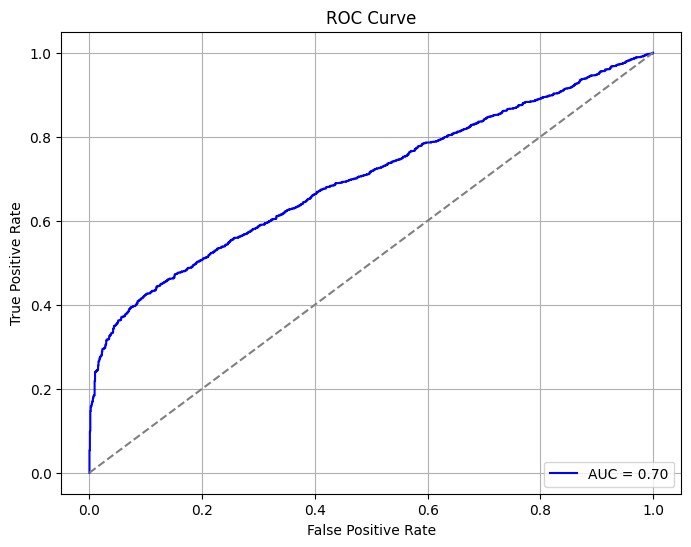

In [30]:
#creating curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()